In [115]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import vmap
from jax import jit, lax, grad
import matplotlib.pyplot as plt
import cmocean as cmo
import importlib

In [2]:
from jax.config import config
config.update("jax_enable_x64", True)

In [3]:
## import modules
import bbmm.utils.preconditioner as precond
import bbmm.utils.conjugate_gradient as cg
import bbmm.functions.pivoted_cholesky as pc
import bbmm.functions.pivoted_cholesky_ref as pc_ref # to use this script we need "torch", please comment out if not needed.
import bbmm.utils.calc_logdet as calc_logdet
import bbmm.utils.calc_trace as calc_trace
import bbmm.operators.dense_linear_operator as dense_linear_operator
import bbmm.operators.root_linear_operator as root_linear_operator
import bbmm.operators.diag_linear_operator as diag_linear_operator
import bbmm.operators._linear_operator as _linear_operator
import bbmm.operators.psd_sum_linear_operator as psd_sum_linear_operator
import bbmm.operators.root_linear_operator as root_linear_operator
from bbmm.functions.pivoted_cholesky_numpy import pivoted_cholesky_numpy
def reload():
    importlib.reload(precond)
    importlib.reload(cg)
    importlib.reload(pc)
    importlib.reload(pc_ref)
    importlib.reload(calc_logdet)
    importlib.reload(calc_trace)
    importlib.reload(dense_linear_operator)
    importlib.reload(root_linear_operator)
    importlib.reload(diag_linear_operator)
    importlib.reload(_linear_operator)
    importlib.reload(psd_sum_linear_operator)
    importlib.reload(root_linear_operator)
reload()

/home/ogawa_kenta/.conda/envs/mytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import gpytorch
import torch
import linear_operator
from linear_operator.operators import (
    AddedDiagLinearOperator,
    DiagLinearOperator,
    LinearOperator,
    DenseLinearOperator,
)

In [5]:
def generate_K(N, seed=0, noise=1e-06):
    """
    generate positive definite symmetric matrix
    """
    K = jax.random.normal(jax.random.PRNGKey(seed), (N, N))
    # K = K @ K.T + 30* jnp.eye(N) + noise*jnp.eye(N)
    # K = jnp.dot(K, K.T) + noise*jnp.eye(N)
    # K = jnp.dot(K, K.T) / N
    K = jnp.dot(K, K.T)/N
    # K += (noise+30)*jnp.eye(N) ## ??
    K += (2)*jnp.eye(N)
    K += (noise)*jnp.eye(N)
    if not is_positive_definite(K):
        raise Exception("K is not positive definite !")
    return K

In [6]:
def is_positive_definite(matrix):
    # 行列の固有値を計算
    eigenvalues = np.linalg.eigvals(matrix)

    # 全ての固有値が正であるかをチェック
    if np.all(eigenvalues > 0):
        return True
    else:
        return False

In [7]:
def rel_error(true, pred):
    nonzero_index = jnp.where(true != 0.)
    true = true[nonzero_index]
    pred = pred[nonzero_index]
    return jnp.mean(jnp.abs((true-pred)/true))

In [8]:
def calc_logdet_linalg(K):
    L = jnp.linalg.cholesky(K)
    return jnp.sum(jnp.log(jnp.diag(L))) * 2

In [9]:
from stopro.data_generator.sinusoidal import Sinusoidal
from stopro.data_generator.sin_1D_naive import Sin1DNaive
from stopro.data_preparer.data_preparer import DataPreparer
from stopro.sub_modules.load_modules import load_params, load_data
from stopro.sub_modules.loss_modules import hessian, logposterior
from stopro.sub_modules.init_modules import get_init, reshape_init
import stopro.GP.gp_sinusoidal_independent as gp_sinusoidal_independent
import stopro.GP.gp_1D_naive as gp_1D_naive
from stopro.data_handler.data_handle_module import HdfOperator
from stopro.GP.kernels import define_kernel

In [10]:
project_name = 'data'
simulation_name = 'test_loss_sin1d_naive'

In [429]:
# data_preparer = DataPreparer(
#     project_name, simulation_name, class_data_generator=Sin1DNaive)
# data_preparer.load_params(
#     system_name="sin_1D_naive", use_existing_params=False
# )
# # data_preparer.params_generate_training[''] = 1000

# data_preparer.create_directory()

# data_preparer.make_data()
# data_preparer.save_params_prepare()
# data_preparer.save_params_main()
# data_preparer.save_lbls()

In [12]:
params_main, params_prepare, lbls = load_params(f"{project_name}/{simulation_name}/data_input")
params_model = params_main["model"]
params_optimization = params_main["optimization"]
params_plot = params_prepare["plot"]
vnames = params_prepare["vnames"]
params_setting = params_prepare["setting"]
params_generate_training = params_prepare["generate_training"]
params_generate_test = params_prepare["generate_test"]
params_kernel_arg = params_prepare["kernel_arg"]

# prepare initial hyper-parameter
init = get_init(
    params_model["init_kernel_hyperparameter"],
    params_model["kernel_type"],
    system_type=params_model["system_type"],
)

In [120]:
# prepare data
hdf_operator = HdfOperator(f"{project_name}/{simulation_name}")
r_test, μ_test, r_train, μ_train, f_train = load_data(lbls, vnames, hdf_operator)
delta_y_train = jnp.empty(0)
for i in range(len(r_train)):
    delta_y_train = jnp.append(delta_y_train, f_train[i] - μ_train[i])

args_predict = r_test, μ_test, r_train, delta_y_train, params_model["epsilon"]
noise = params_model["epsilon"]

### setup model

In [116]:
# setup model
Kernel = define_kernel(params_model)
gp_model = gp_1D_naive.GPmodel1DNaive(
    Kernel=Kernel,
)
gp_model.set_constants(*args_predict)
loglikelihood, predictor = (
    gp_model.trainingFunction_all,
    gp_model.predictingFunction_all,
)
func = jit(logposterior(loglikelihood, params_optimization))
dfunc = jit(grad(func, 0))
hess = hessian(func)

In [16]:
init

DeviceArray([0., 0.], dtype=float64)

## check $K^{-1}y$

In [313]:
K = gp_model.trainingK_all(init, r_train)
K_torch = torch.from_numpy(np.array(K))
K_tilde = gp_model.add_eps_to_sigma(K, noise, noise_parameter=None)

In [314]:
is_positive_definite(K), jnp.linalg.cond(K)

(True, DeviceArray(2197.77391808, dtype=float64))

In [315]:
np.max(K)

DeviceArray(1., dtype=float64)

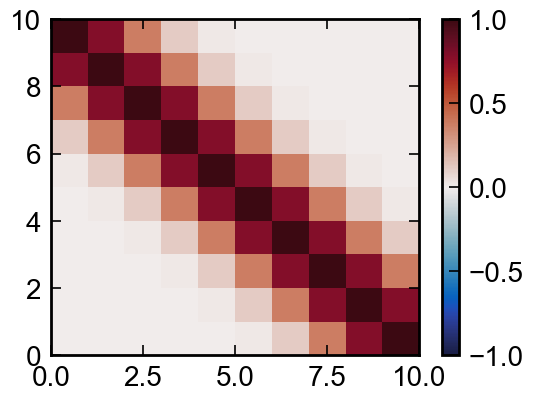

In [316]:
fig, ax = plt.subplots()
mappable = ax.pcolormesh(np.flipud(K), vmin=-np.max(K), vmax=np.max(K), cmap=cmo.cm.balance)
fig.colorbar(mappable)

In [395]:
rank=15
n_tridiag = 10
K_torch = torch.from_numpy(np.array(K))

In [396]:
precondition, precond_lt, precond_logdet_cache = precond.setup_preconditioner(K_tilde, rank=rank, noise=noise)
if precondition:
    zs = precond_lt_new.zero_mean_mvn_samples(n_tridiag, seed=0)
else:
    zs = jax.random.normal(jax.random.PRNGKey(0), (len(delta_y_train), n_tridiag))
zs_norms = jnp.linalg.norm(zs, axis=0, keepdims=True)
zs = zs/zs_norms
rhs = jnp.concatenate([zs, delta_y_train.reshape(-1, 1)], axis=1)
rhs_torch = torch.from_numpy(np.array(rhs))

In [397]:
Kinvy_linalg = jnp.linalg.solve(K_tilde, rhs)

In [398]:
Kinvy, j,t_mat = cg.mpcg_bbmm(
    K_tilde,
    rhs,
    precondition=precondition, 
    print_process=True, 
    tolerance=0.01, 
    n_tridiag=n_tridiag, 
    max_tridiag_iter=40
)
print(rel_error(Kinvy_linalg, Kinvy))

j=0 r1norm: 1.0389475355140048
j=1 r1norm: 1.3332554532691703
j=2 r1norm: 1.4907779174341962
j=3 r1norm: 1.3898973798515903
j=4 r1norm: 1.6930401770169745
j=5 r1norm: 1.3916386467102402
j=6 r1norm: 1.155598497885101
j=7 r1norm: 0.616627390768565
j=8 r1norm: 0.1778318416580003
j=9 r1norm: 7.938460475356269e-07
j=10 r1norm: 7.938460475356269e-07
converged
1.3902734082083188e-09


### check logdet

In [400]:
logdet = calc_logdet.calc_logdet(K_tilde.shape, t_mat, precond_logdet_cache)
logdet_linalg = calc_logdet_linalg(K_tilde)
logdet, logdet_linalg

(DeviceArray(-15.92293263, dtype=float64),
 DeviceArray(-15.95991311, dtype=float64))

In [401]:
K_linear_op = linear_operator.to_linear_operator(K_torch)
diag_tensor = torch.ones(len(delta_y_train), dtype=torch.float64)*noise
diag_linear_op = DiagLinearOperator(diag_tensor)
added_diag = AddedDiagLinearOperator(K_linear_op, diag_linear_op)

In [402]:
linear_operator.settings.num_trace_samples.value()
linear_operator.settings.min_preconditioning_size._set_value(2000)

In [403]:
linear_operator.settings.num_trace_samples._set_value(10)
linear_operator.settings.max_preconditioner_size._set_value(15)

In [425]:
added_diag.inv_quad_logdet(inv_quad_rhs=rhs_torch[:, -1:], logdet=True)

(tensor(2.7265, dtype=torch.float64), tensor(-15.9599, dtype=torch.float64))

In [405]:
from linear_operator.operators.identity_linear_operator import IdentityLinearOperator

In [406]:
precond_lt_torch_new = IdentityLinearOperator(
                diag_shape=added_diag.size(-1),
                batch_shape=added_diag.batch_shape,
                dtype=added_diag.dtype,
                device=added_diag.device,
            )

In [407]:
probe_vectors = precond_lt_torch_new.zero_mean_mvn_samples(n_tridiag)
probe_vectors = probe_vectors.unsqueeze(-2).transpose(0, -2).squeeze(0).mT.contiguous()
probe_vector_norms = torch.norm(probe_vectors, p=2, dim=-2, keepdim=True)
probe_vectors = probe_vectors.div(probe_vector_norms)

In [408]:
probe_vector_norms

tensor([[2.5265, 3.5100, 3.1789, 1.9372, 2.9361, 3.6594, 3.8677, 2.9670, 4.0258,
         2.8209]], dtype=torch.float64)

In [409]:
jnp.linalg.norm(zs, axis=0)

DeviceArray([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float64)

In [411]:
torch.norm(probe_vectors, p=2, dim=-2)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], dtype=torch.float64)

In [385]:
rhs_torch.shape

torch.Size([10, 11])

In [417]:
torch.from_numpy(np.array(delta_y_train.reshape(-1, 1))).shape

torch.Size([10, 1])

In [419]:
rhs_torch_new = torch.cat((probe_vectors, torch.from_numpy(np.array(delta_y_train.reshape(-1, 1)))), dim=-1)

In [422]:
preconditioner_torch, precond_lt_torch, precond_logdet_torch = added_diag._preconditioner()
# Kinvy_torch, t_mat_torch = added_diag._solve(rhs_torch, preconditioner=preconditioner_torch, num_tridiag=10)
Kinvy_torch, t_mat_torch = added_diag._solve(rhs_torch_new, preconditioner=preconditioner_torch, num_tridiag=10)
# print(rel_error(Kinvy_linalg, Kinvy_torch.numpy()))
linear_operator.settings.cg_tolerance._set_value(0.01)

In [423]:
eval_torch, evec_torch = linear_operator.utils.lanczos.lanczos_tridiag_to_diag(t_mat_torch)
slq = linear_operator.utils.stochastic_lq.StochasticLQ()
(logdet_term,) = slq.to_dense(added_diag.matrix_shape, eval_torch, evec_torch,  [lambda x: x.log()])
if precond_logdet_torch:
    logdet_torch = logdet_term + precond_logdet_torch
else:
    logdet_torch = logdet_term
logdet_torch

tensor(-18.1140, dtype=torch.float64)

## 5. calc_loss

In [194]:
def loss_linalg(K, y):
    Kinvy_linalg = jnp.linalg.solve(K, y)
    logdet_linalg = calc_logdet_linalg(K)
    yKy_linalg = jnp.dot(y, Kinvy_linalg)
    loss = (yKy_linalg + logdet_linalg)/2 + len(y)/2*jnp.log(jnp.pi*2)
    print(yKy_linalg)
    print(logdet_linalg)
    return loss

In [195]:
loss_linalg(K, delta_y_train)

2.7265948373123687
-15.960740558220376


DeviceArray(2.57231247, dtype=float64)

In [131]:
gp_model.trainingFunction_all(init, *args_predict[2:])

DeviceArray(2.57268269, dtype=float64)

In [196]:
likelihood = gp_model.trainingFunction_all
grad(likelihood, 0)(init, *args_predict[2:])

DeviceArray([  3.63637595, -17.89689526], dtype=float64)

In [232]:
def setup_loss_mpcg(rank=15, n_tridiag=10, seed=0, tolerance=0.01):
    def loss_mpcg(init, *args):

        r, delta_y, noise = args

        K = gp_model.trainingK_all(init, r)
        K = gp_model.add_eps_to_sigma(K, noise, noise_parameter=None)

        perecondition, precond_lt, precond_logdet_cache = precond.setup_preconditioner(K, rank=rank, noise=noise)
        if precondition:
            zs = precond_lt.zero_mean_mvn_samples(n_tridiag, seed=0)
            zs_norms = jnp.linalg.norm(zs, axis=0, keepdims=True)
            zs = zs/zs_norms
        else:
            zs = jax.random.normal(jax.random.PRNGKey(0), (len(delta_y), n_tridiag))
        rhs = jnp.concatenate([zs, delta_y.reshape(-1, 1)], axis=1)

        Kinvy, j,t_mat = cg.mpcg_bbmm(
            K,
            rhs,
            precondition=precondition, 
            print_process=False, 
            tolerance=tolerance, 
            n_tridiag=n_tridiag, 
            max_tridiag_iter=20
        )

        logdet = calc_logdet.calc_logdet(K.shape, t_mat, precond_logdet_cache)

        yKy = jnp.dot(delta_y, Kinvy[:, -1])
        loss = (yKy + logdet)/2 + len(delta_y)/2*jnp.log(jnp.pi*2)    
        # print(yKy)
        # print(logdet)
        return loss
    return loss_mpcg

In [223]:
likelihood_mpcg = setup_loss_mpcg()

In [224]:
likelihood_mpcg(init, *args_predict[2:])

DeviceArray(2.59117293, dtype=float64)

In [225]:
grad(likelihood_mpcg, 0)(init, *args_predict[2:])

DeviceArray([  3.63620687, -17.44486165], dtype=float64)

In [234]:
def check_ll(n_tridiag=10, rank=15, tolerance=0.01, min_preconditioning_size=2000):
    likelihood = gp_model.trainingFunction_all
    ll_ref = likelihood(init, *args_predict[2:])
    dll_ref = grad(likelihood, 0)(init, *args_predict[2:])
    ll_list = []
    dll_list = []
    for i in range(10):
        likelihood_mpcg = setup_loss_mpcg(seed=9, n_tridiag=n_tridiag, rank=rank, tolerance=tolerance)
        ll_mpcg = likelihood_mpcg(init, *args_predict[2:])
        dll_mpcg = grad(likelihood_mpcg, 0)(init, *args_predict[2:])
        ll_list.append(ll_mpcg)
        dll_list.append(dll_mpcg)
    ll_mean = np.mean(ll_list)
    ll_relative_error = np.mean(np.abs((ll_ref-np.array(ll_list))/ll_ref))
    dll_relative_error = np.mean(np.abs((dll_ref-np.array(dll_list))/dll_ref))
    return ll_mean, ll_relative_error, dll_relative_error

In [310]:
n_tridiag_list = [2, 5, 10]
ll_list = []
ll_rel_error_list = []
dll_rel_error_list = []
for n_tridiag in n_tridiag_list:
    ll, ll_rel_err, dll_rel_err = check_ll(n_tridiag=n_tridiag)
    ll_list.append(ll)
    ll_rel_error_list.append(ll_rel_err)
    dll_rel_error_list.append(dll_rel_err)

In [311]:
likelihood = gp_model.trainingFunction_all
ll_ref = likelihood(init, *args_predict[2:])
dll_ref = grad(likelihood, 0)(init, *args_predict[2:])

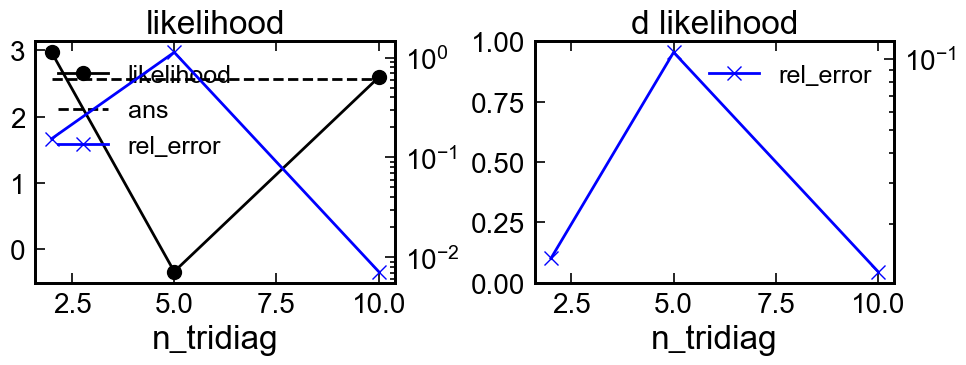

In [312]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
ax = axs[0]
ax.plot(n_tridiag_list, ll_list, marker='o', label='likelihood')
ax.hlines(ll_ref, n_tridiag_list[0], n_tridiag_list[-1], linestyle='--', label='ans')
ax.set_xlabel('n_tridiag')
ax2 = ax.twinx()
ax2.semilogy(n_tridiag_list, ll_rel_error_list, color='b', marker='x', label='rel_error')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
# Create a legend for the first line in each axes
ax.legend(lines + lines2, labels + labels2, loc='best')
ax.set_title('likelihood')

ax = axs[1]
# ax.plot(n_tridiag_list, dll_list, marker='o', label='dlikelihood')
# ax.hlines(ll_ref, n_tridiag_list[0], n_tridiag_list[-1], linestyle='--', label='ans')
ax.set_xlabel('n_tridiag')
ax2 = ax.twinx()
ax2.semilogy(n_tridiag_list, dll_rel_error_list, color='b', marker='x', label='rel_error')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
# Create a legend for the first line in each axes
ax.legend(lines + lines2, labels + labels2, loc='best')

ax.set_title('d likelihood')

plt.tight_layout()